In [1]:
# ms-python.python added
from fbprophet import Prophet
import os
try:
    os.chdir(os.path.join(os.getcwd(), 'prediction'))
    print(os.getcwd())
except:
    pass

 # Data Analysis and Prediction Notebook

 ## Import library

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
import datetime as dt
import time


 ## Establish the Database connection

In [3]:
env_var = 'MY_SQL_IP'
database = "localhost" if env_var not in os.environ else os.environ['MY_SQL_IP']
db_connection_str = f"mysql+pymysql://vlay:123@{database}:3306/madbox"

# Retry to connect until we connect to the database
for i in range(20):
    try:
        db_connection = create_engine(db_connection_str)

        # Retrieve data from a select *
        sql_str = """
        SELECT * FROM madbox_api
        """

        # Put the data into a dataframe
        df = pd.read_sql(sql_str, db_connection)\
            .reset_index()\
            .assign(
            cmp=lambda x: x['spend'] / x['nb_impressions'],
            gpm=lambda x: x['profit'] / x['nb_impressions'],
            day_name=lambda x: x['date'].dt.weekday_name,
        )\
            .set_index(['date'])\
            .drop(['index'], axis='columns')
    except Exception as e:
        time.sleep(5)
        print(e)

df.assign(
    # recomputation of the metrics to understand how it works
    profit_calculated=lambda x: x['revenue'] - x['spend'],
    margin_calculated=lambda x: x['profit'] / x['revenue'],
    ecpm_calculated=lambda x: x['revenue'] / x['nb_impressions'] * 1000,
)



,spend,revenue,profit,margin,nb_impressions,ecpm,cmp,gpm,day_name,profit_calculated,margin_calculated,ecpm_calculated
date,,,,,,,,,,,,
2019-01-01,2001.90,3068.28,1066.37,0.35,60581.17,50.65,0.033045,0.017602,Tuesday,1066.38,0.347547,50.647421
2019-01-02,2054.01,3101.48,1047.46,0.34,63095.41,49.16,0.032554,0.016601,Wednesday,1047.47,0.337729,49.155398
2019-01-03,2134.73,3188.27,1053.55,0.33,64883.31,49.14,0.032901,0.016238,Thursday,1053.54,0.330446,49.138523
2019-01-04,2074.41,3128.17,1053.76,0.34,64387.51,48.58,0.032218,0.016366,Friday,1053.76,0.336861,48.583491
2019-01-05,2161.50,3110.78,949.28,0.31,64160.22,48.48,0.033689,0.014795,Saturday,949.28,0.305158,48.484559
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-03,2961.48,4441.75,1480.27,0.33,90735.48,48.95,0.032639,0.016314,Tuesday,1480.27,0.333263,48.952736
2019-09-04,3228.75,4944.24,1715.50,0.35,98790.21,50.05,0.032683,0.017365,Wednesday,1715.49,0.346969,50.047874
2019-09-05,3275.66,4936.66,1661.00,0.34,98986.39,49.87,0.033092,0.016780,Thursday,1661.00,0.336462,49.872109


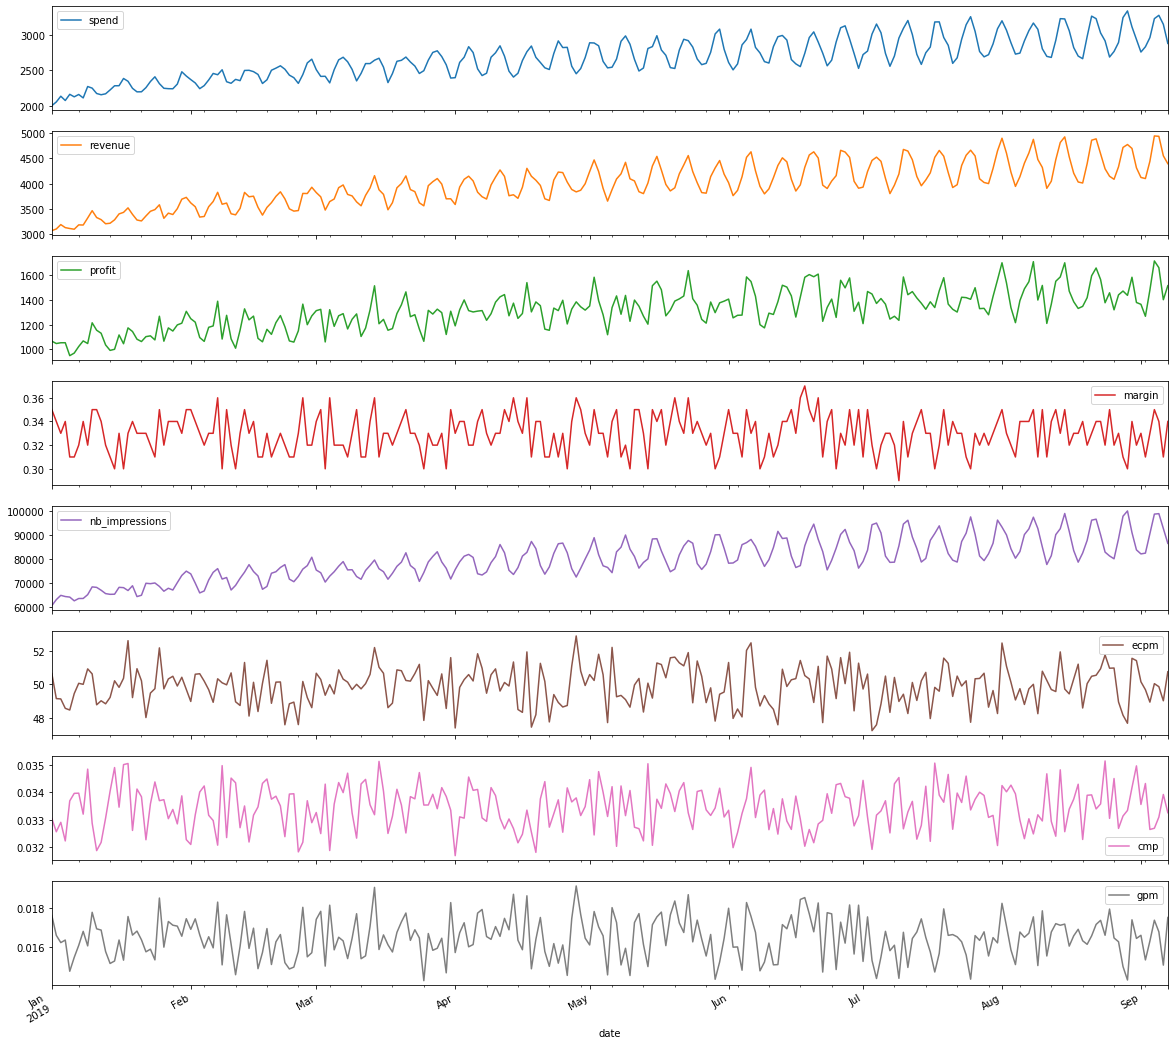

In [4]:
pd.plotting.register_matplotlib_converters()
df.plot(subplots=True, figsize=(20, 20))
plt.show()

Text(0.5, 1.05, 'Correlation Matrix')

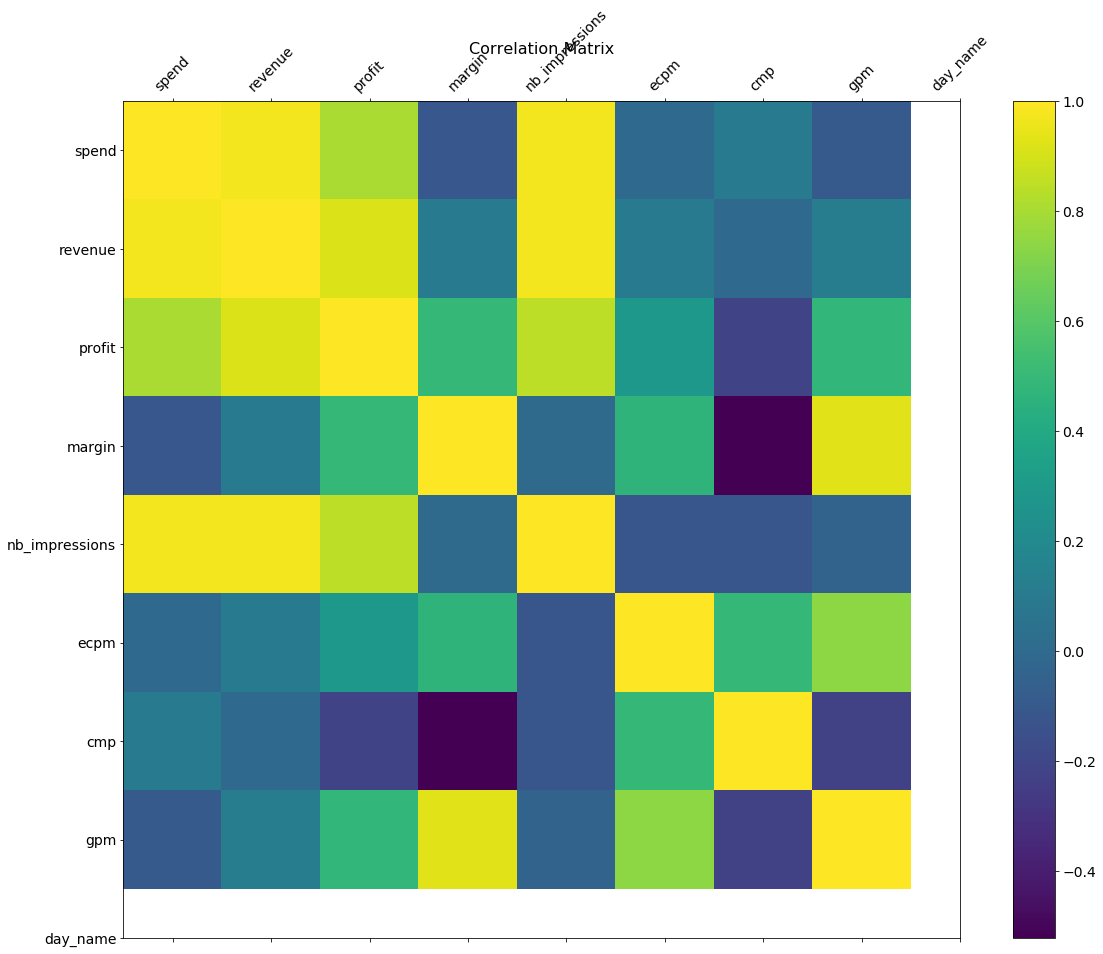

In [5]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

 ## Keeping only relevant data

In [6]:
df = df[['spend', 'revenue', 'nb_impressions']]


 ## Facebook Prophet Model

 ### Look for the optimal parameters

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1, 'Revenue Forecast')

<Figure size 2160x720 with 0 Axes>

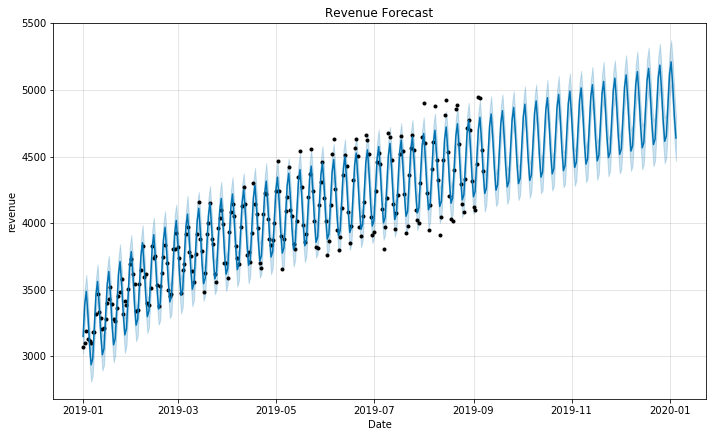

In [7]:

revenue = df['revenue'].reset_index().rename(
    columns={'date': 'ds', 'revenue': 'y'})
model = Prophet()
model.fit(revenue)
revenue_forecast = model.make_future_dataframe(periods=120, freq='D')
revenue_forecast = model.predict(revenue_forecast)
plt.figure(figsize=(30, 10))
model.plot(revenue_forecast, xlabel='Date', ylabel='revenue')
plt.title('Revenue Forecast')



In [8]:
revenue_forecast



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,3159.841294,3021.180590,3268.476082,3159.841294,3159.841294,-11.683129,-11.683129,-11.683129,-11.683129,-11.683129,-11.683129,0.0,0.0,0.0,3148.158165
1,2019-01-02,3170.559094,3258.043594,3505.584677,3170.559094,3170.559094,214.767892,214.767892,214.767892,214.767892,214.767892,214.767892,0.0,0.0,0.0,3385.326986
2,2019-01-03,3181.276895,3354.010255,3610.374610,3181.276895,3181.276895,304.797562,304.797562,304.797562,304.797562,304.797562,304.797562,0.0,0.0,0.0,3486.074457
3,2019-01-04,3191.994695,3185.646813,3435.173020,3191.994695,3191.994695,122.858855,122.858855,122.858855,122.858855,122.858855,122.858855,0.0,0.0,0.0,3314.853551
4,2019-01-05,3202.712496,2968.678671,3217.073844,3202.712496,3202.712496,-109.816207,-109.816207,-109.816207,-109.816207,-109.816207,-109.816207,0.0,0.0,0.0,3092.896288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,2020-01-01,4903.047767,4946.155206,5284.696952,4788.435458,5020.661032,214.767892,214.767892,214.767892,214.767892,214.767892,214.767892,0.0,0.0,0.0,5117.815660
366,2020-01-02,4906.544608,5037.623123,5373.605119,4790.173973,5025.999122,304.797562,304.797562,304.797562,304.797562,304.797562,304.797562,0.0,0.0,0.0,5211.342170
367,2020-01-03,4910.041448,4855.863091,5216.452050,4793.263418,5031.564158,122.858855,122.858855,122.858855,122.858855,122.858855,122.858855,0.0,0.0,0.0,5032.900303
368,2020-01-04,4913.538288,4624.807369,4989.264486,4795.714994,5036.314545,-109.816207,-109.816207,-109.816207,-109.816207,-109.816207,-109.816207,0.0,0.0,0.0,4803.722080


Text(0.5, 1, 'Revenue Forecast Components')

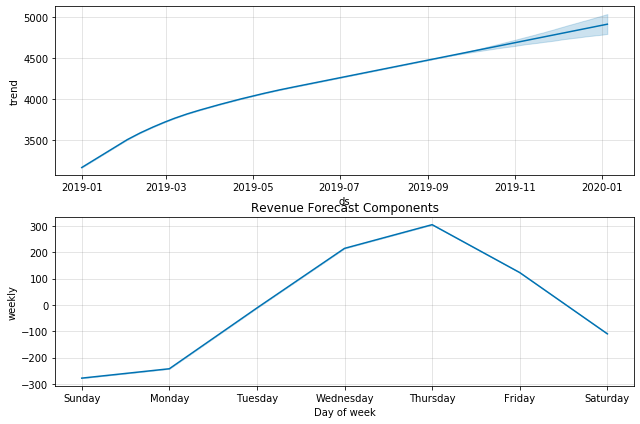

In [9]:
model.plot_components(revenue_forecast)
plt.title('Revenue Forecast Components')



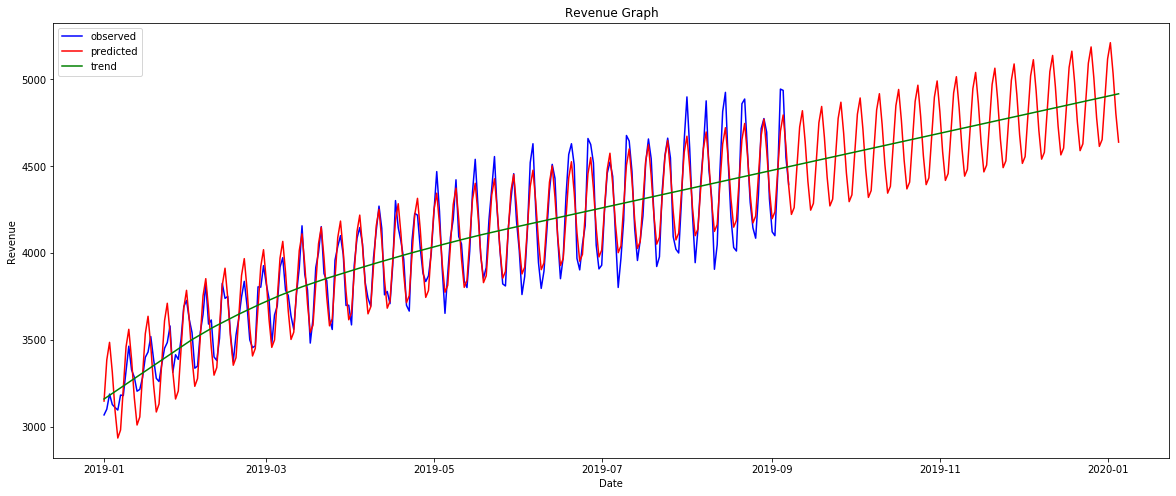

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(revenue['ds'], revenue['y'], 'b-', label='observed')
plt.plot(revenue_forecast['ds'],
         revenue_forecast['yhat'], 'r-', label='predicted')
plt.plot(revenue_forecast['ds'],
         revenue_forecast['trend'], 'g-', label='trend')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue Graph')
plt.legend()


 # Prediction

In [11]:
pred_lst = []
for col in list(df.columns):
    data = df[col].reset_index().rename(columns={'date': 'ds', col: 'y'})
    model = Prophet()
    model.fit(data)
    data_forecast = model.make_future_dataframe(periods=120, freq='D')
    data_forecast = model.predict(data_forecast)
    data_forecast = data_forecast                        .rename(
        {'ds': 'date', 'yhat': col, 'trend': col + '_trend'}, axis='columns')                        .set_index(['date'])[[col, col + '_trend']]
    pred_lst.append(data_forecast)

pred_df = pd.concat(pred_lst, axis='columns')
pred_df



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,spend,spend_trend,revenue,revenue_trend,nb_impressions,nb_impressions_trend
date,,,,,,
2019-01-01,2120.123634,2123.062633,3148.158165,3159.841294,63761.963479,63465.927132
2019-01-02,2280.059851,2129.991796,3385.326986,3170.559094,67930.003299,63677.367361
2019-01-03,2334.925106,2136.920959,3486.074457,3181.276895,70200.600195,63888.807590
2019-01-04,2224.159935,2143.850123,3314.853551,3191.994695,66280.217149,64100.247819
2019-01-05,2074.569035,2150.779286,3092.896288,3202.712496,61779.599805,64311.688048
...,...,...,...,...,...,...
2020-01-01,3460.690847,3310.622792,5117.815660,4903.047767,102435.222583,98182.586646
2020-01-02,3511.120319,3313.116172,5211.342170,4906.544608,104563.894425,98252.101819
2020-01-03,3395.919363,3315.609551,5032.900303,4910.041448,100501.586324,98321.616993


In [12]:
trend_df = pred_df[:len(df)].drop(
    df.columns, axis='columns')            .assign(category='observed')
df = pd.concat([df, trend_df], axis='columns')

df



,spend,revenue,nb_impressions,spend_trend,revenue_trend,nb_impressions_trend,category
date,,,,,,,
2019-01-01,2001.90,3068.28,60581.17,2123.062633,3159.841294,63465.927132,observed
2019-01-02,2054.01,3101.48,63095.41,2129.991796,3170.559094,63677.367361,observed
2019-01-03,2134.73,3188.27,64883.31,2136.920959,3181.276895,63888.807590,observed
2019-01-04,2074.41,3128.17,64387.51,2143.850123,3191.994695,64100.247819,observed
2019-01-05,2161.50,3110.78,64160.22,2150.779286,3202.712496,64311.688048,observed
...,...,...,...,...,...,...,...
2019-09-03,2961.48,4441.75,90735.48,3011.417251,4483.426954,89840.765789,observed
2019-09-04,3228.75,4944.24,98790.21,3013.910630,4486.923794,89910.280963,observed
2019-09-05,3275.66,4936.66,98986.39,3016.404010,4490.420635,89979.796137,observed


In [13]:
pred_df = pred_df[len(df):]            .assign(category='prediction')
pred_df



,spend,spend_trend,revenue,revenue_trend,nb_impressions,nb_impressions_trend,category
date,,,,,,,
2019-09-08,2831.541652,3023.884148,4222.653588,4500.911155,84171.773612,90188.341658,prediction
2019-09-09,2869.487260,3026.377528,4261.740588,4504.407995,85766.078899,90257.856832,prediction
2019-09-10,3025.931908,3028.870907,4496.221706,4507.904835,90623.408353,90327.372006,prediction
2019-09-11,3181.432342,3031.364287,4726.169567,4511.401675,94649.523117,90396.887179,prediction
2019-09-12,3231.861813,3033.857667,4819.696078,4514.898515,96778.194959,90466.402353,prediction
...,...,...,...,...,...,...,...
2020-01-01,3460.690847,3310.622792,5117.815660,4903.047767,102435.222583,98182.586646,prediction
2020-01-02,3511.120319,3313.116172,5211.342170,4906.544608,104563.894425,98252.101819,prediction
2020-01-03,3395.919363,3315.609551,5032.900303,4910.041448,100501.586324,98321.616993,prediction


In [14]:
df = pd.concat([df, pred_df], axis='rows', sort=True)        .sort_index()
df



,category,nb_impressions,nb_impressions_trend,revenue,revenue_trend,spend,spend_trend
date,,,,,,,
2019-01-01,observed,60581.170000,63465.927132,3068.280000,3159.841294,2001.900000,2123.062633
2019-01-02,observed,63095.410000,63677.367361,3101.480000,3170.559094,2054.010000,2129.991796
2019-01-03,observed,64883.310000,63888.807590,3188.270000,3181.276895,2134.730000,2136.920959
2019-01-04,observed,64387.510000,64100.247819,3128.170000,3191.994695,2074.410000,2143.850123
2019-01-05,observed,64160.220000,64311.688048,3110.780000,3202.712496,2161.500000,2150.779286
...,...,...,...,...,...,...,...
2020-01-01,prediction,102435.222583,98182.586646,5117.815660,4903.047767,3460.690847,3310.622792
2020-01-02,prediction,104563.894425,98252.101819,5211.342170,4906.544608,3511.120319,3313.116172
2020-01-03,prediction,100501.586324,98321.616993,5032.900303,4910.041448,3395.919363,3315.609551


In [15]:
df.dtypes


category                 object
nb_impressions          float64
nb_impressions_trend    float64
revenue                 float64
revenue_trend           float64
spend                   float64
spend_trend             float64
dtype: object

 # DataFrame into DataBase

In [16]:
df.to_sql('metrics', db_connection, if_exists='replace')
